# Comparative Analysis of Activation Functions in CBAM's **Channel** Attention Module

## 0. Set-up

In [29]:
pip install sparsemax

In [30]:
# Import all necessary libraries for model building, training,
# evaluation, visualization, and dataset preparation.

import torch                     # PyTorch core
import torch.nn as nn            # PyTorch neural network module
import torch.optim as optim      # PyTorch optimization algorithms
from torchvision import models, transforms
from torchvision.datasets import CIFAR10, STL10
from torch.utils.data import DataLoader
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import numpy as np
from sparsemax import Sparsemax

# Set computation device to GPU if available
device = torch.device("cuda")
print(f"Running on: {device}")

Running on: cuda


## 1. Data loading and preprocessing


In [31]:
def get_dataloaders(dataset="cifar10"):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
    return trainloader, testloader, 10

##3. Building Attention Enhanced Convolutional Neural Network (CNN) models



### CBAM MODULE: Convolutional Block Attention Module

The CBAM mechanism consists of two attention mechanisms:
 - Channel attention: Learns 'what' to focus on
 - Spatial attention: Learns 'where' to focus on

In [32]:
# A simple building block for convolution + optional batch norm and ReLU
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()

        # Standard convolutional layer
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=bias)

        # Optional batch normalization (if bn)
        self.bn = nn.BatchNorm2d(out_planes) if bn else None

        # Optional ReLU activation (if relu)
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        # Apply convolution
        x = self.conv(x)
        # Apply batch normalization if enabled
        if self.bn is not None:
            x = self.bn(x)
        # Apply ReLU if enabled
        if self.relu is not None:
            x = self.relu(x)
        return x # Return the processed feature map

### Step 1: Channel Attention Module

---
#### * Activation Functions to Output Values for Each Channel Position
**Sigmoid (default)**: Allows multiple regions to be highlighted. No competition, so the model can attend to several important areas.

**Softmax**: Forces competition, so only the most salient region gets high weight. Might help in tasks where a single dominant region is key, but could suppress other important areas.

**Scaled Tanh**: By scaling and shifting tanh, it keeps the output in [0,1]. The learnable scale might adapt the sensitivity.

**Parametric Sigmoid**: The temperature parameter allows adjusting the steepness of the sigmoid. A higher temperature makes it softer, spreading out the attention, while a lower temperature makes it sharper.

**Swish**: Combines the input with its sigmoid, potentially allowing non-monotonic behaviour. Might provide better gradients during training, leading to faster convergence or better performance.

**Sparsemax**: Designed to produce sparse probabilities. This would result in only a few spatial positions being active, effectively focusing on very specific regions.



In [33]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16, channel_activation_type='sigmoid'):
        super(ChannelAttention, self).__init__()
        # Adaptive pooling: compress feature maps to 1x1 by averaging and maxing across channel dimensions
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP: two conv layers simulate a fully connected bottleneck structure
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)

        # For condition
        self.activation_type = channel_activation_type

        # Learnable parameter
        self.scale = nn.Parameter(torch.ones(1))
        self.temperature = nn.Parameter(torch.ones(1))

        # Activation functions
        self.sparsemax = Sparsemax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out

        if self.activation_type == 'softmax':
            B, C, _, _ = out.shape
            out = out.view(B, C, -1)
            out = self.softmax(out)
            out = out.view(B, C, 1, 1)

        elif self.activation_type == 'sparsemax':
            B, C, _, _ = out.shape
            out = out.view(B, C, -1)
            out = self.sparsemax(out)
            out = out.view(B, C, 1, 1)

        elif self.activation_type == 'scaled_tanh':
            out = self.tanh(self.scale * out)
            out = (out + 1) / 2  # normalize to [0,1]

        elif self.activation_type == 'parametric_sigmoid':
            out = self.sigmoid(out / self.temperature)

        elif self.activation_type == 'swish':
            out = out * torch.sigmoid(out)
            out = torch.clamp(out, 0, 1)

        else:
            out = self.sigmoid(out)

        return out


### Step 2: Spatial Attention Module




---




In [35]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, spatial_activation_type='sigmoid'):
        super(SpatialAttention, self).__init__()

        # Padding must match kernel size to keep dimensions consistent.
        # Must ensure that attention map is the same spatial size as the input feature map
        padding = 3 if kernel_size == 7 else 1

        # 7x7 convolution on 2-channel input (avg + max across channels)
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

        # For condition
        self.activation_type = spatial_activation_type

        # Learnable parameter
        self.scale = nn.Parameter(torch.ones(1))
        self.temperature = nn.Parameter(torch.ones(1))

        # Activation functions
        self.sparsemax = Sparsemax(dim=-1)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Channel-wise pooling to summarize across channels
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)

        B, C, H, W = x.shape

        if self.activation_type == 'softmax':
            x = x.view(B, -1)
            x = self.softmax(x)
            x = x.view(B, 1, H, W)

        elif self.activation_type == 'sparsemax':
            x = x.view(B, -1)
            x = self.sparsemax(x)
            x = x.view(B, 1, H, W)

        elif self.activation_type == 'scaled_tanh':
            x = self.tanh(self.scale * x)
            x = (x + 1) / 2

        elif self.activation_type == 'parametric_sigmoid':
            x = self.sigmoid(x / self.temperature)

        elif self.activation_type == 'swish':
            x = x * torch.sigmoid(x)
            x = torch.clamp(x, 0, 1)

        else:
            x = self.sigmoid(x)

        return x

In [36]:
# Combines channel and spatial attention in sequence
class CBAM(nn.Module):
    def __init__(self, planes, ratio=16, kernel_size=7, spatial_activation_type='sigmoid', channel_activation_type='sigmoid'):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(planes, ratio, channel_activation_type=channel_activation_type)
        self.sa = SpatialAttention(kernel_size, spatial_activation_type=spatial_activation_type)

    def forward(self, x):
        x = x * self.ca(x)  # Apply channel attention first
        x = x * self.sa(x) # Then apply spatial attention
        return x  # Return the feature map with attention applied

### Step3: Adding CBAM to CNN architectures

This section wraps VGG19, ResNet18, and InceptionV3 with CBAM at early, middle, or late layer locations.

In [37]:
# Helper function that inserts CBAM into a Sequential model at a specified index

def insert_cbam_sequential(module, index, cbam_module):
    layers = list(module.children()) # Breaks the existing Sequential into a list of layers
    layers.insert(index, cbam_module) # Inserts CBAM at the desired point
    return nn.Sequential(*layers)  # Reassemble - (* is the Python unpacking util: turns a list of layers into multiple arguments)

ResNet with CBAM:

- Custom ResNet18 wrapper that conditionally adds CBAM at different depths

In [38]:
class ResNet18_CBAM(nn.Module):
    def __init__(self, attention_position="middle", num_classes=10, spatial_activation_type='sigmoid', channel_activation_type='sigmoid'):
        super(ResNet18_CBAM, self).__init__()
        base = models.resnet18(pretrained=True)  # Load pretrained ResNet18

        # Load pretrained ResNet18
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.layer1 = base.layer1 # Output: 64 channels
        self.layer2 = base.layer2 # Output: 128 channels
        self.layer3 = base.layer3 # Output: 256 channels
        self.layer4 = base.layer4 # Output: 512 channels
        self.avgpool = base.avgpool
        self.fc = nn.Linear(512, num_classes)


        # Conditionally attach CBAM to a specific ResNet block depending on the attention_position specified (CBAM is added to the first block in the specified layer group)
        # If 'none', this is passed over - we skip adding any attention block
        if attention_position == "early":
            self.layer1[0].cbam = CBAM(64, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type)
        elif attention_position == "middle":
            self.layer2[0].cbam = CBAM(128, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type)
        elif attention_position == "late":
            self.layer4[0].cbam = CBAM(512, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        # Apply CBAM only if attached
        if hasattr(self.layer1[0], 'cbam'):
            x = self.layer1[0].cbam(x)
        x = self.layer2(x)
        if hasattr(self.layer2[0], 'cbam'):
            x = self.layer2[0].cbam(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if hasattr(self.layer4[0], 'cbam'):
            x = self.layer4[0].cbam(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


Inception with CBAM:

In [ ]:
# Inception_CBAM code here...

Function that takes the architecture and position where attention is to be added. `num_classes` is always 10 because that is how many categories CIFAR10 AND SLT10 have.

In [39]:
def get_attention_model(base='vgg', position='middle', num_classes=10, spatial_activation_type = 'sigmoid', channel_activation_type='sigmoid'):
    if base == 'vgg':
        return VGG19_CBAM(attention_position=position, num_classes=num_classes)
    elif base == 'resnet':
        return  ResNet18_CBAM(attention_position=position, num_classes=num_classes, spatial_activation_type=spatial_activation_type, channel_activation_type=channel_activation_type)
    elif base == 'inception':
        return print("coming soon...")


## 4. Training & Evaluation

Includes Top-1, Top-5, Average Precision and (work in progress) gradient flow plot

In [40]:
def train_model(model, trainloader, testloader, num_classes=10, epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_model_wts = copy.deepcopy(model.state_dict()) # Keeps a copy of the best version of model
    best_acc = 0.0
    grad_norms = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_norm = 0.0

        for inputs, labels in tqdm(trainloader): # tqdm wrapper gives a neat visual indicator of how training is progressing
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # L2 norm of all the gradients across every trainable parameter in the model
            norm = sum(p.grad.data.norm(2).item() for p in model.parameters() if p.grad is not None)
            total_norm += norm

            optimizer.step()
            running_loss += loss.item()

        grad_norms.append(total_norm / len(trainloader))
        top1, top5, ap = evaluate_model(model, testloader, num_classes)

        print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, GradNorm={grad_norms[-1]:.4f}, Top1={top1:.2f}%, Top5={top5:.2f}%, AP={ap:.4f}")

        if top1 > best_acc:
            best_acc = top1
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    plt.plot(range(1, epochs+1), grad_norms, marker='o')
    plt.title("Gradient Norm per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Gradient L2 Norm")
    plt.grid(True)
    plt.show()
    return model

In [41]:
def evaluate_model(model, testloader, num_classes):
    model.eval()
    total, correct1, correct5 = 0, 0, 0
    y_true, y_scores = [], []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred1 = outputs.topk(1, dim=1)
            _, pred5 = outputs.topk(5, dim=1)
            correct1 += (pred1.squeeze() == labels).sum().item()
            correct5 += sum([labels[i].item() in pred5[i] for i in range(len(labels))])
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.softmax(dim=1).cpu().numpy())

    y_true_bin = nn.functional.one_hot(torch.tensor(y_true), num_classes=num_classes)
    ap_score = average_precision_score(y_true_bin, y_scores)
    return 100 * correct1 / total, 100 * correct5 / total, ap_score

## 5. Experimenting with different combinations

This cell runs experiments for all **7 combinations** :

1 architectures (resnet)

x 1 datasets (cifar10)

x 2 attention positions (none, late)

x 6 activation functions (parametric sigmoid, sparsemax, swish, sigmoid, softmax, scaled_tanh)



Running: RESNET | Dataset: CIFAR10 | Attention: late | Activation: softmax


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 1: Loss=1329.6897, GradNorm=6.2914, Top1=39.25%, Top5=91.71%, AP=0.4119


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 2: Loss=1110.4085, GradNorm=7.1652, Top1=46.07%, Top5=95.24%, AP=0.4956


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 3: Loss=915.2608, GradNorm=7.0553, Top1=58.34%, Top5=97.55%, AP=0.6613


100%|██████████| 782/782 [02:45<00:00,  4.74it/s]


Epoch 4: Loss=734.9135, GradNorm=8.5756, Top1=68.47%, Top5=97.01%, AP=0.7708


100%|██████████| 782/782 [02:44<00:00,  4.75it/s]


Epoch 5: Loss=546.6726, GradNorm=10.4538, Top1=78.55%, Top5=98.38%, AP=0.8602


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 6: Loss=417.4533, GradNorm=11.1118, Top1=83.12%, Top5=98.61%, AP=0.8961


100%|██████████| 782/782 [02:44<00:00,  4.75it/s]


Epoch 7: Loss=333.1460, GradNorm=11.3333, Top1=84.57%, Top5=98.74%, AP=0.9178


100%|██████████| 782/782 [02:44<00:00,  4.74it/s]


Epoch 8: Loss=260.9461, GradNorm=11.1168, Top1=85.89%, Top5=98.90%, AP=0.9295


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 9: Loss=216.8808, GradNorm=11.2929, Top1=85.83%, Top5=98.66%, AP=0.9313


100%|██████████| 782/782 [02:44<00:00,  4.74it/s]


Epoch 10: Loss=170.6389, GradNorm=10.7729, Top1=86.73%, Top5=98.99%, AP=0.9317


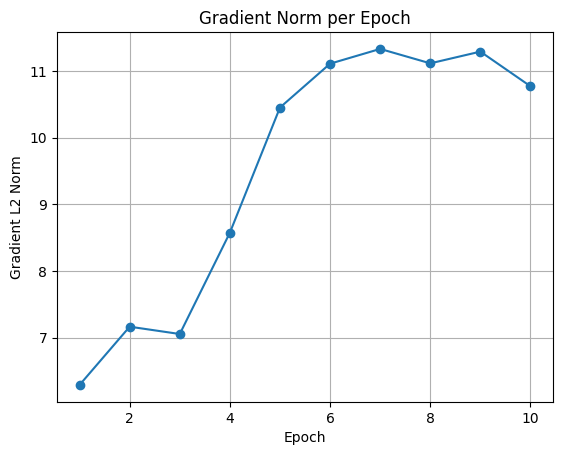


Running: RESNET | Dataset: CIFAR10 | Attention: late | Activation: scaled_tanh


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 1: Loss=454.0635, GradNorm=12.8440, Top1=83.84%, Top5=99.43%, AP=0.9323


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 2: Loss=251.3412, GradNorm=9.9926, Top1=88.11%, Top5=99.71%, AP=0.9559


100%|██████████| 782/782 [02:45<00:00,  4.74it/s]


Epoch 3: Loss=174.4772, GradNorm=9.2722, Top1=89.05%, Top5=99.63%, AP=0.9615


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 4: Loss=122.6597, GradNorm=8.5798, Top1=88.92%, Top5=99.65%, AP=0.9595


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 5: Loss=92.8052, GradNorm=8.0041, Top1=89.28%, Top5=99.67%, AP=0.9610


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 6: Loss=68.0037, GradNorm=7.4637, Top1=90.39%, Top5=99.59%, AP=0.9638


100%|██████████| 782/782 [02:44<00:00,  4.74it/s]


Epoch 7: Loss=58.4383, GradNorm=7.2085, Top1=90.65%, Top5=99.56%, AP=0.9680


100%|██████████| 782/782 [02:45<00:00,  4.74it/s]


Epoch 8: Loss=49.9395, GradNorm=6.8023, Top1=90.16%, Top5=99.79%, AP=0.9660


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 9: Loss=43.5678, GradNorm=6.5122, Top1=90.44%, Top5=99.65%, AP=0.9666


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 10: Loss=37.2664, GradNorm=5.8848, Top1=90.78%, Top5=99.65%, AP=0.9669


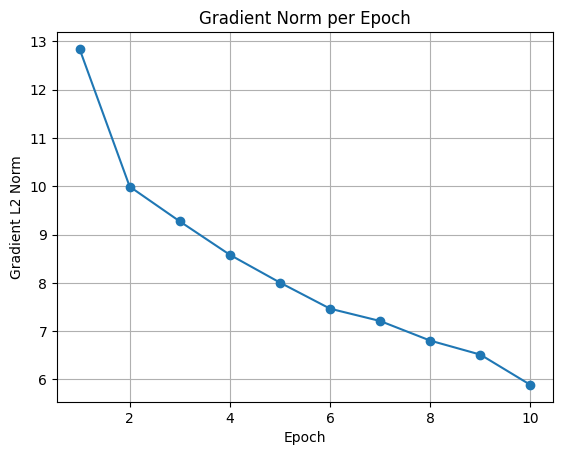


Running: RESNET | Dataset: CIFAR10 | Attention: late | Activation: parametric_sigmoid


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [02:46<00:00,  4.71it/s]


Epoch 1: Loss=443.0355, GradNorm=12.7012, Top1=84.31%, Top5=99.17%, AP=0.9289


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 2: Loss=253.6049, GradNorm=9.9581, Top1=87.78%, Top5=99.65%, AP=0.9516


100%|██████████| 782/782 [02:46<00:00,  4.71it/s]


Epoch 3: Loss=172.8699, GradNorm=9.1030, Top1=89.33%, Top5=99.59%, AP=0.9587


100%|██████████| 782/782 [02:46<00:00,  4.69it/s]


Epoch 4: Loss=121.7523, GradNorm=8.5864, Top1=89.34%, Top5=99.74%, AP=0.9622


100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 5: Loss=89.5987, GradNorm=8.0403, Top1=90.50%, Top5=99.72%, AP=0.9663


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 6: Loss=72.9363, GradNorm=7.6141, Top1=89.84%, Top5=99.64%, AP=0.9630


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 7: Loss=51.8602, GradNorm=6.7513, Top1=90.50%, Top5=99.64%, AP=0.9648


100%|██████████| 782/782 [02:45<00:00,  4.74it/s]


Epoch 8: Loss=54.4968, GradNorm=7.2954, Top1=89.11%, Top5=99.66%, AP=0.9598


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 9: Loss=42.8034, GradNorm=6.3091, Top1=90.45%, Top5=99.66%, AP=0.9644


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 10: Loss=38.1759, GradNorm=6.0421, Top1=90.46%, Top5=99.64%, AP=0.9654


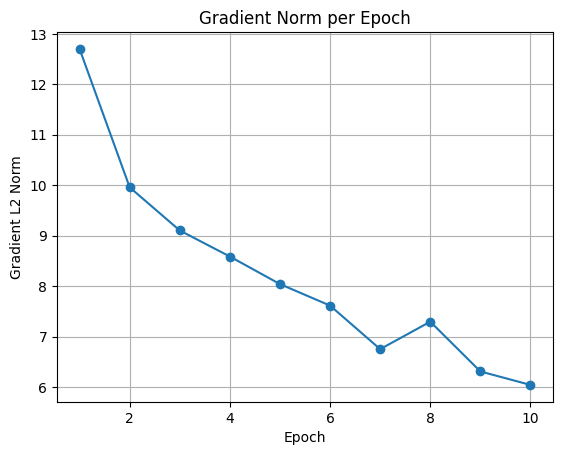


Running: RESNET | Dataset: CIFAR10 | Attention: late | Activation: swish


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 1: Loss=449.3524, GradNorm=13.1848, Top1=85.57%, Top5=99.40%, AP=0.9407


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 2: Loss=252.7160, GradNorm=10.1073, Top1=88.81%, Top5=99.56%, AP=0.9561


100%|██████████| 782/782 [02:45<00:00,  4.71it/s]


Epoch 3: Loss=171.7306, GradNorm=9.1614, Top1=88.12%, Top5=99.62%, AP=0.9591


100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 4: Loss=121.5133, GradNorm=8.5759, Top1=90.71%, Top5=99.73%, AP=0.9666


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 5: Loss=90.4130, GradNorm=8.1163, Top1=88.05%, Top5=99.60%, AP=0.9573


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 6: Loss=74.3454, GradNorm=7.6525, Top1=89.12%, Top5=99.63%, AP=0.9600


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 7: Loss=54.1525, GradNorm=6.7919, Top1=90.16%, Top5=99.62%, AP=0.9636


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 8: Loss=49.2704, GradNorm=6.6110, Top1=89.01%, Top5=99.54%, AP=0.9583


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 9: Loss=44.8725, GradNorm=6.6258, Top1=90.91%, Top5=99.74%, AP=0.9682


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 10: Loss=39.3088, GradNorm=6.0946, Top1=89.91%, Top5=99.70%, AP=0.9644


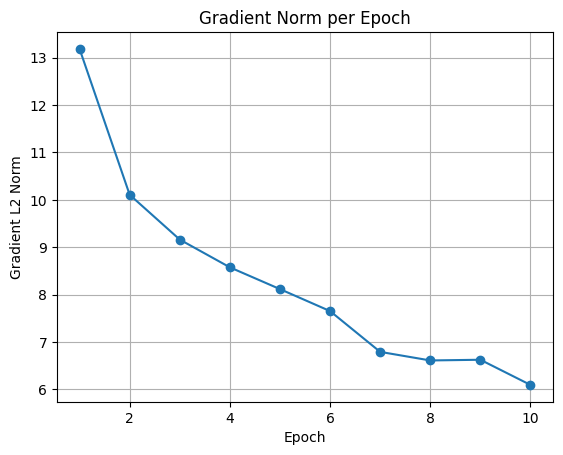


Running: RESNET | Dataset: CIFAR10 | Attention: late | Activation: sparsemax


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 1: Loss=1521.4470, GradNorm=2.5826, Top1=24.42%, Top5=88.51%, AP=0.3218


100%|██████████| 782/782 [02:46<00:00,  4.69it/s]


Epoch 2: Loss=1355.5063, GradNorm=3.8184, Top1=35.82%, Top5=92.67%, AP=0.3731


100%|██████████| 782/782 [02:46<00:00,  4.69it/s]


Epoch 3: Loss=1272.1941, GradNorm=4.5381, Top1=44.83%, Top5=94.78%, AP=0.4493


100%|██████████| 782/782 [02:47<00:00,  4.67it/s]


Epoch 4: Loss=1100.0613, GradNorm=5.3233, Top1=54.99%, Top5=96.97%, AP=0.5760


100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 5: Loss=987.7908, GradNorm=6.8440, Top1=26.91%, Top5=80.76%, AP=0.2832


100%|██████████| 782/782 [02:46<00:00,  4.69it/s]


Epoch 6: Loss=934.5645, GradNorm=7.2579, Top1=64.30%, Top5=97.38%, AP=0.7000


100%|██████████| 782/782 [02:47<00:00,  4.67it/s]


Epoch 7: Loss=808.6327, GradNorm=7.9333, Top1=68.12%, Top5=97.72%, AP=0.7366


100%|██████████| 782/782 [02:47<00:00,  4.67it/s]


Epoch 8: Loss=724.8488, GradNorm=8.8482, Top1=69.42%, Top5=98.00%, AP=0.7414


100%|██████████| 782/782 [02:47<00:00,  4.67it/s]


Epoch 9: Loss=644.3388, GradNorm=9.2078, Top1=73.62%, Top5=97.95%, AP=0.7870


100%|██████████| 782/782 [02:46<00:00,  4.68it/s]


Epoch 10: Loss=581.1070, GradNorm=9.9696, Top1=75.36%, Top5=98.01%, AP=0.8021


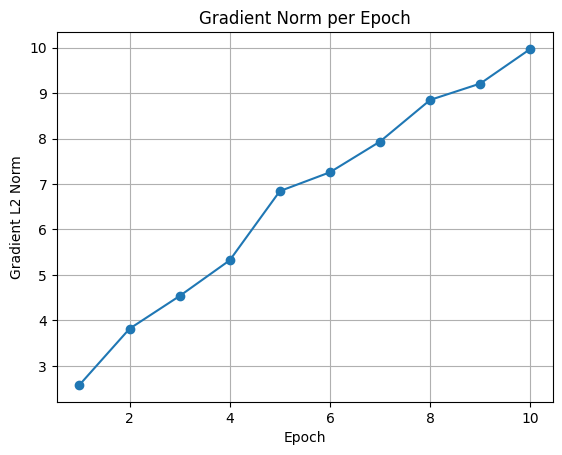


Running: RESNET | Dataset: CIFAR10 | Attention: late | Activation: sigmoid


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [02:46<00:00,  4.69it/s]


Epoch 1: Loss=446.1380, GradNorm=12.9095, Top1=84.61%, Top5=99.34%, AP=0.9295


100%|██████████| 782/782 [02:46<00:00,  4.69it/s]


Epoch 2: Loss=248.5308, GradNorm=10.0036, Top1=86.70%, Top5=99.56%, AP=0.9468


100%|██████████| 782/782 [02:45<00:00,  4.71it/s]


Epoch 3: Loss=174.8345, GradNorm=9.2314, Top1=88.49%, Top5=99.61%, AP=0.9574


100%|██████████| 782/782 [02:46<00:00,  4.71it/s]


Epoch 4: Loss=124.4935, GradNorm=8.6412, Top1=89.99%, Top5=99.76%, AP=0.9649


100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 5: Loss=96.6725, GradNorm=8.2530, Top1=89.22%, Top5=99.54%, AP=0.9599


100%|██████████| 782/782 [02:45<00:00,  4.71it/s]


Epoch 6: Loss=68.7872, GradNorm=7.5928, Top1=89.28%, Top5=99.57%, AP=0.9616


100%|██████████| 782/782 [02:46<00:00,  4.71it/s]


Epoch 7: Loss=54.3698, GradNorm=6.8110, Top1=89.09%, Top5=99.53%, AP=0.9601


100%|██████████| 782/782 [02:46<00:00,  4.71it/s]


Epoch 8: Loss=53.2120, GradNorm=7.0858, Top1=88.79%, Top5=99.55%, AP=0.9582


100%|██████████| 782/782 [02:46<00:00,  4.70it/s]


Epoch 9: Loss=42.8976, GradNorm=6.4280, Top1=90.57%, Top5=99.69%, AP=0.9647


100%|██████████| 782/782 [02:46<00:00,  4.71it/s]


Epoch 10: Loss=39.4181, GradNorm=6.1899, Top1=91.06%, Top5=99.71%, AP=0.9696


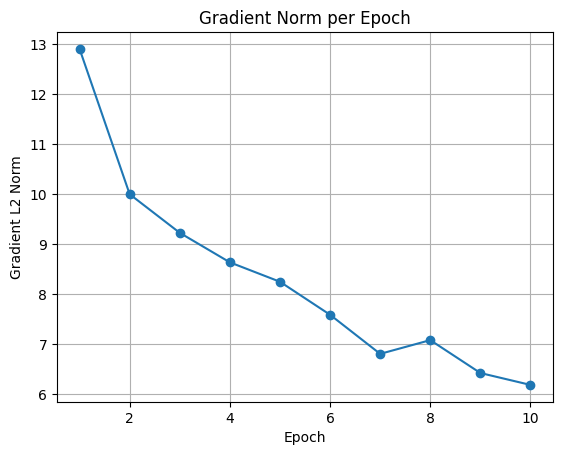


Running: RESNET | Dataset: CIFAR10 | Attention: None | Activation: N/A


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 1: Loss=440.8868, GradNorm=14.3202, Top1=85.26%, Top5=99.25%, AP=0.9330


100%|██████████| 782/782 [02:44<00:00,  4.74it/s]


Epoch 2: Loss=250.0632, GradNorm=10.5680, Top1=88.37%, Top5=99.46%, AP=0.9531


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 3: Loss=172.7351, GradNorm=9.5585, Top1=89.12%, Top5=99.53%, AP=0.9612


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 4: Loss=128.0126, GradNorm=8.9798, Top1=88.05%, Top5=99.68%, AP=0.9602


100%|██████████| 782/782 [02:45<00:00,  4.73it/s]


Epoch 5: Loss=97.4385, GradNorm=8.5865, Top1=89.16%, Top5=99.68%, AP=0.9605


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 6: Loss=76.0777, GradNorm=8.0703, Top1=89.68%, Top5=99.64%, AP=0.9652


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 7: Loss=64.3206, GradNorm=7.8024, Top1=90.92%, Top5=99.63%, AP=0.9685


100%|██████████| 782/782 [02:45<00:00,  4.72it/s]


Epoch 8: Loss=51.3116, GradNorm=7.0129, Top1=90.14%, Top5=99.69%, AP=0.9651


100%|██████████| 782/782 [02:44<00:00,  4.74it/s]


Epoch 9: Loss=49.9661, GradNorm=7.0546, Top1=90.40%, Top5=99.66%, AP=0.9645


100%|██████████| 782/782 [02:45<00:00,  4.74it/s]


Epoch 10: Loss=39.8988, GradNorm=6.4025, Top1=88.22%, Top5=99.55%, AP=0.9570


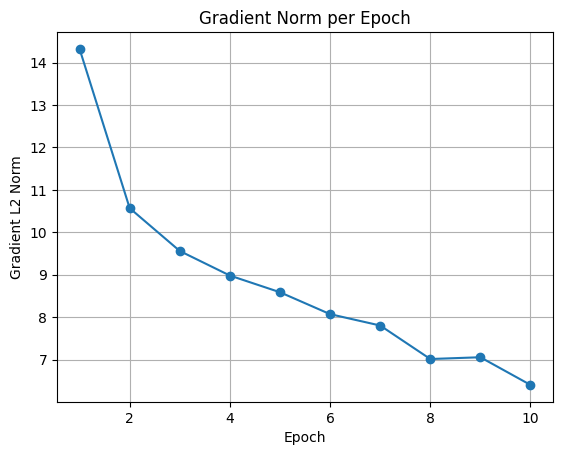


All experiments complete. Summary:


,architecture,dataset,attention_position,channel_activation,top1,top5,ap
0,resnet,cifar10,late,softmax,86.73,98.99,0.931717
1,resnet,cifar10,late,scaled_tanh,90.78,99.65,0.966850
2,resnet,cifar10,late,parametric_sigmoid,90.50,99.72,0.966316
3,resnet,cifar10,late,swish,90.91,99.74,0.968151
4,resnet,cifar10,late,sparsemax,75.36,98.01,0.802119
5,resnet,cifar10,late,sigmoid,91.06,99.71,0.969565
6,resnet,cifar10,none,none,90.92,99.63,0.968457


In [42]:
architectures = ['resnet'] #['vgg', 'resnet', 'inception']
datasets = ['cifar10']
positions = ['late', None]
spatial_activation_types = []
channel_activation_types = ['softmax', 'scaled_tanh', 'parametric_sigmoid', 'swish', 'sparsemax', 'sigmoid']

results = []

for arch in architectures:
    for ds in datasets:
        for pos in positions:
            for channel_activation in channel_activation_types if pos is not None else [None]:
                print(f"\nRunning: {arch.upper()} | Dataset: {ds.upper()} | "
                      f"Attention: {pos or 'None'} | Activation: {channel_activation or 'N/A'}")

                trainloader, testloader, num_classes = get_dataloaders(ds)

                if pos is None:
                    # Load vanilla model without CBAM
                    if arch == 'vgg':
                        model = models.vgg19(pretrained=True)
                        model.classifier[-1] = nn.Linear(4096, num_classes)
                    elif arch == 'resnet':
                        model = models.resnet18(pretrained=True)
                        model.fc = nn.Linear(512, num_classes)
                else:
                    # Load model with CBAM using specified activation
                    model = get_attention_model(
                        base=arch,
                        position=pos,
                        num_classes=num_classes,
                        channel_activation_type=channel_activation
                    )

                model = model.to(device)
                trained_model = train_model(model, trainloader, testloader, num_classes=num_classes, epochs=10)

                top1, top5, ap = evaluate_model(trained_model, testloader, num_classes)
                results.append({
                    'architecture': arch,
                    'dataset': ds,
                    'attention_position': pos or 'none',
                    'channel_activation': channel_activation or 'none',
                    'top1': top1,
                    'top5': top5,
                    'ap': ap
                })

# Display results
import pandas as pd
summary = pd.DataFrame(results)
print("\nAll experiments complete. Summary:")
display(summary)